In [1]:
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage

base_directory = "../"
sys.path.insert(0, base_directory)

output_directory = "./output/noise-tests/sd2-notebook/autoencoder"

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e)

os.makedirs(output_directory, exist_ok=True)

from stable_diffusion2.latent_diffusion import LatentDiffusion
from stable_diffusion2.stable_diffusion import StableDiffusion
from stable_diffusion2.utils.model import *
from stable_diffusion2.utils.utils import SectionManager as section
from stable_diffusion2.utils.utils import *
from stable_diffusion2.model.clip.clip_embedder import CLIPTextEmbedder



from stable_diffusion2.model.unet.unet import UNetModel

from pathlib import Path
from os.path import join

device = get_device()
to_pil = lambda image: ToPILImage()(torch.clamp((image + 1.0) / 2.0, min=0.0, max=1.0))

[WinError 3] The system cannot find the path specified: './output/noise-tests/sd2-notebook/autoencoder'
INFO: Using CUDA device: NVIDIA GeForce RTX 3080 Ti


In [2]:
#define the logistic distribution
def logistic_distribution(loc, scale):
    base_distribution = torch.distributions.Uniform(0, 1)
    transforms = [torch.distributions.transforms.SigmoidTransform().inv, torch.distributions.transforms.AffineTransform(loc=loc, scale=scale)]
    logistic = torch.distributions.TransformedDistribution(base_distribution, transforms)
    return logistic
noise_fn = lambda shape, device = device: logistic_distribution(loc=0.0, scale=0.5).sample(shape).to(device)

In [3]:
#initialize an empty stable diffusion class
stable_diffusion_model = StableDiffusion(device=device)
get_memory_status();

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11084 MiB
Used: 1203 MiB


In [4]:
#load the latent diffusion model from disk
stable_diffusion_model.model.load_submodel_tree()
get_memory_status();

Starting section: load submodel tree...
Finished section: load submodel tree in 4.95 seconds

Total: 12287 MiB
Free: 6932 MiB
Used: 5355 MiB


In [5]:
#unload the latent diffusion model submodels
stable_diffusion_model.unload_model()
torch.cuda.empty_cache()
get_memory_status();

Total: 12287 MiB
Free: 11084 MiB
Used: 1203 MiB


In [6]:
#intialize a stable diffusion model with a ddim_eta parameter and load submodel tree
ddim_eta = 0.1
stable_diffusion_model = StableDiffusion(device = device, ddim_eta=ddim_eta)
stable_diffusion_model.model.load_submodel_tree()
get_memory_status();

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Starting section: load submodel tree...
Finished section: load submodel tree in 2.69 seconds

Total: 12287 MiB
Free: 6932 MiB
Used: 5355 MiB


HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

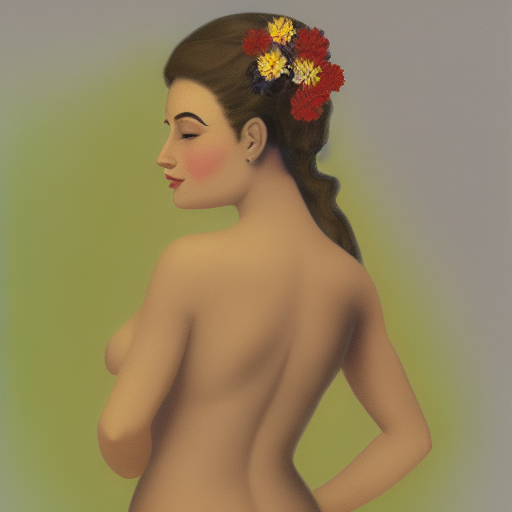

In [7]:
# choose a temperature for the sampling (higher means more diversity but less quality) and generate an image, then save it and show it
temperature = 1.2
imgs = stable_diffusion_model.generate_images(
    prompt = 'A woman with flowers in her hair in a courtyard, in the style of Frank Frazetta',
    seed = 2982,
    noise_fn = noise_fn,
    temperature = temperature,
    )

save_images(imgs, join(output_directory, f'test_sample.png'))
to_pil(imgs[0])

In [8]:
#unload the latent diffusion model submodels
stable_diffusion_model.unload_model()
del imgs
torch.cuda.empty_cache()
get_memory_status();

Total: 12287 MiB
Free: 9986 MiB
Used: 2301 MiB


In [9]:
#load an image to test the autoencoder module
img = load_img("./input/test_img.jpg").to(device)
get_memory_status();

Total: 12287 MiB
Free: 9986 MiB
Used: 2301 MiB


In [10]:
#load the autoencoder submodel (it's a submodel of the latent diffusion model)
stable_diffusion_model.model.load_autoencoder()
get_memory_status();

Total: 12287 MiB
Free: 9986 MiB
Used: 2301 MiB


In [11]:
#load the encoder submodel (it's a submodel of the autoencoder)
stable_diffusion_model.model.autoencoder.load_encoder()
get_memory_status();

Total: 12287 MiB
Free: 9846 MiB
Used: 2441 MiB


In [12]:
#get the latent representation of the test image
encoded_img = stable_diffusion_model.encode(img)
get_memory_status();

Total: 12287 MiB
Free: 9136 MiB
Used: 3151 MiB


In [13]:
encoded_img.shape

torch.Size([1, 4, 64, 64])

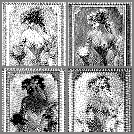

In [14]:
#show each dimension of the latent representation
grid = torchvision.utils.make_grid(encoded_img.permute(1, 0, 2, 3), nrow=2, normalize=False, range=(-1, 1), scale_each=True, pad_value=0)
dim_grid_image = to_pil(grid)
dim_grid_image.save(join(output_directory, f'encoding_dimensions_grid.png'))
dim_grid_image

In [15]:
#save it as a tensor
torch.save(encoded_img, join(output_directory, f'encoded_img_temp{temperature}_eta{ddim_eta:.3f}.pt'))

In [16]:
del encoded_img
torch.cuda.empty_cache()
print(get_memory_status())

Total: 12287 MiB
Free: 9846 MiB
Used: 2441 MiB
(tensor(9846), tensor(12287))


In [17]:
#load it back
encoded_img = torch.load(join(output_directory, f'encoded_img_temp{temperature}_eta{ddim_eta:.3f}.pt'))
torch.cuda.empty_cache()
get_memory_status()


Total: 12287 MiB
Free: 9846 MiB
Used: 2441 MiB


(tensor(9846), tensor(12287))

In [18]:
encoded_img.shape

torch.Size([1, 4, 64, 64])

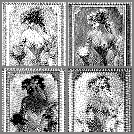

In [19]:
grid = torchvision.utils.make_grid(encoded_img.permute(1, 0, 2, 3), nrow=2, normalize=False, range=(-1, 1), scale_each=True, pad_value=0)
to_pil(grid)

In [20]:
del grid
torch.cuda.empty_cache()
get_memory_status();

Total: 12287 MiB
Free: 9846 MiB
Used: 2441 MiB


In [21]:
#unload the encoder submodel
stable_diffusion_model.model.autoencoder.unload_encoder()
torch.cuda.empty_cache()
get_memory_status();

Total: 12287 MiB
Free: 9986 MiB
Used: 2301 MiB


In [22]:
#load the decoder submodel
stable_diffusion_model.model.autoencoder.load_decoder()
torch.cuda.empty_cache()
get_memory_status();

Total: 12287 MiB
Free: 9786 MiB
Used: 2501 MiB


Total: 12287 MiB
Free: 9786 MiB
Used: 2501 MiB


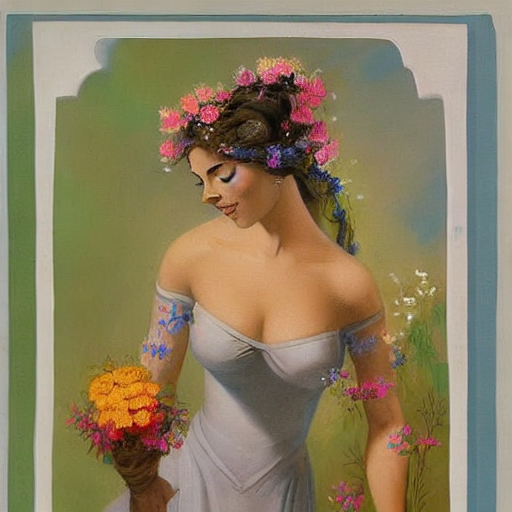

In [23]:
#decode the latent representation that we loaded from disk
decoded_img = stable_diffusion_model.decode(encoded_img)
save_images(decoded_img, join(output_directory, f'decoded_img_temp{temperature}_eta{ddim_eta:.3f}.png'))
torch.cuda.empty_cache()
get_memory_status();
to_pil(decoded_img[0])